### ImageDataGenerator 적용

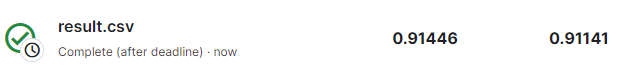

In [87]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

### 이미지 전처리

In [88]:

"./plant-pathology-2020-fgvc7/images/"

IMAGE_PATH = "./plant-pathology-2020-fgvc7/images/"
TEST_PATH = "./plant-pathology-2020-fgvc7/test.csv"
TRAIN_PATH = "./plant-pathology-2020-fgvc7/train.csv"
SUB_PATH = "./plant-pathology-2020-fgvc7/sample_submission.csv"

test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)

def load_image(image_id):
    file_path = image_id + ".jpg"
    image = cv2.imread(IMAGE_PATH + file_path)
    
    # 이미지 크기 확인
    height, width, _ = image.shape
    
    # 이미지 크기가 (2048, 1365)일 경우 회전하여 크기 변경
    if height == 2048 and width == 1365:
        image = np.rot90(image)

    # 이미지를 1/4 크기로 줄이기
    image = cv2.resize(image, (224, 224))

    return image

    #return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

train_images = train_data["image_id"][:].apply(load_image)



In [89]:
images = np.stack(train_images)
labels = train_data[["healthy", "multiple_diseases", "rust", "scab"]].values

In [90]:
from sklearn.model_selection import train_test_split
# 데이터를 균등하게 분할하여 검증 세트를 생성
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, stratify=labels)

In [91]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rotation_range=30,
                                   shear_range=0.7,
                                   zoom_range=[0.9, 2.2],
                                   fill_mode='nearest'
                                   )

val_datagen = ImageDataGenerator(rescale=1./255)

In [92]:
BATCH_SIZE = 5
train_generator = train_datagen.flow(x=train_images, y=train_labels, batch_size=BATCH_SIZE, shuffle=True)
val_generator = train_datagen.flow(x=val_images, y=val_labels, batch_size=BATCH_SIZE, shuffle=True)

In [97]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

16705208/16705208 [==============================] - 2s 0us/step


ValueError: The last dimension of the inputs to a Dense layer should be defined. Found None. Full input shape received: (None, None)

In [94]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 64)         0

In [95]:
# 학습 및 검증
modelpath = './test.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(train_generator, epochs=70, verbose=1, callbacks=[early_stopping_callback, checkpointer], validation_data=val_generator)

Epoch 1/70
292/292 [==============================] - ETA: 0s - loss: 1.2625 - accuracy: 0.3372
Epoch 1: val_loss improved from inf to 1.25045, saving model to .\test.hdf5
292/292 [==============================] - 18s 43ms/step - loss: 1.2625 - accuracy: 0.3372 - val_loss: 1.2505 - val_accuracy: 0.3781
Epoch 2/70
292/292 [==============================] - ETA: 0s - loss: 1.2341 - accuracy: 0.3606
Epoch 2: val_loss improved from 1.25045 to 1.20997, saving model to .\test.hdf5
292/292 [==============================] - 11s 38ms/step - loss: 1.2341 - accuracy: 0.3606 - val_loss: 1.2100 - val_accuracy: 0.4356
Epoch 3/70
291/292 [============================>.] - ETA: 0s - loss: 1.0580 - accuracy: 0.5582
Epoch 3: val_loss improved from 1.20997 to 0.81441, saving model to .\test.hdf5
292/292 [==============================] - 11s 38ms/step - loss: 1.0563 - accuracy: 0.5591 - val_loss: 0.8144 - val_accuracy: 0.6904
Epoch 4/70
292/292 [==============================] - ETA: 0s - loss: 0.7855 

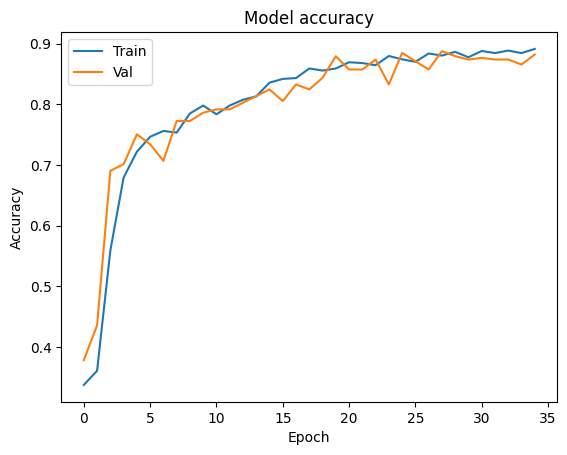

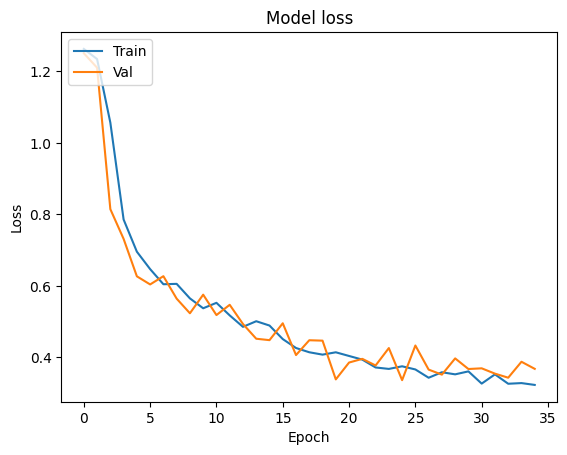

In [96]:
# 6 훈련 과정 시각화 (정확도)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()